This notebook is part of the `kikuchipy` documentation https://kikuchipy.org.
Links to the documentation won't work from the notebook.

# Pattern matching

Crystal orientations can be determined from experimental EBSD patterns by
matching them to a dictionary of simulated patterns of known orientations, see
e.g. <cite data-cite="chen2015dictionary">Chen et al. (2015)</cite>,
<cite data-cite="nolze2016pattern">Nolze et al. (2016)</cite>, 
<cite data-cite="foden2019indexing">Foden et al. (2019)</cite>.

Here, we will demonstrate *dictionary indexing* (DI) using a Ni data set of 4125
EBSD patterns and a dynamically simulated master pattern from EMsoft, both of
low resolution and found in the [kikuchipy.data](../reference.rst#data) module.
The pattern dictionary is generated from a discrete grid of orientations with a
fixed set of projection center (PC) parameters. The true orientation is likely
to fall in between multiple grid points, which means there is always a lower
angular accuracy associated with each DI run. We can improve upon each
orientation by letting it deviate from the discrete grid points. We do this by
maximizing the similarity between experimental and simulated patterns using
numerical optimization algorithms from the
[SciPy library](https://docs.scipy.org/doc/scipy/reference/optimize.html). This
is here called *orientation refinement*. We could instead keep the orientations
fixed and let the PC parameters deviate from their fixed value used in the
dictionary, here called *projection center refinement*. Finally, we can also
refine both at the same time, here called *orientation and projection center
refinement*. The need for orientation or orientation and PC refinement is
discussed in e.g.
<cite data-cite="singh2017application">Singh et al. (2017)</cite>,
<cite data-cite="winkelmann2020refined">Winkelmann et al. (2020)</cite>, and
<cite data-cite="pang2020optimization">Pang et al. (2020)</cite>.

The term *pattern matching* is here used for the combined approach of DI
followed by refinement.

Before we can generate a dictionary of
simulated patterns, we need a master pattern containing all possible scattering
vectors for a candidate phase. This can be simulated using EMsoft
(<cite data-cite="callahan2013dynamical">Callahan and De Graef (2013)</cite> and
<cite data-cite="jackson2014h5ebsd">Jackson et al. (2014)</cite>) and then read
into kikuchipy.

First, we import libraries and load the small experimental Nickel test data

In [1]:
# Exchange inline for notebook or qt5 (from pyqt) for interactive plotting
%matplotlib inline

import tempfile
import matplotlib.pyplot as plt
import hyperspy.api as hs
import numpy as np
from orix import sampling, plot, io
import kikuchipy as kp


plt.rcParams.update({"figure.facecolor": "w", "font.size": 15})

# Use kp.load("data.h5") to load your own data
s = kp.data.nickel_ebsd_large(allow_download=True)  # External download
s

<EBSD, title: patterns Scan 1, dimensions: (75, 55|60, 60)>

To obtain a good match, we must increase the signal-to-noise ratio. In this
pattern matching analysis, the Kikuchi bands are considered the signal, and the
angle-dependent backscatter intensity, along with unwanted detector effects,
are considered to be noise. See the
[pattern processing guide](pattern_processing.rst) for further details.

In [2]:
s.remove_static_background()
s.remove_dynamic_background()

Removing the static background:
[########################################] | 100% Completed |  0.3s
Removing the dynamic background:
[########################################] | 100% Completed |  1.1s


<div class="alert alert-info">

Note

DI is computationally intensive and takes in general a long time to run due to
all the pattern comparisons being done. To maintain an acceptable memory usage
and be done within reasonable time, it is recommended to write processed
patterns to an HDF5 file for quick reading during DI.

</div>

In [3]:
#s.save("pattern_static_dynamic.h5")

## Dictionary indexing

### Load a master pattern

Next, we load a dynamically simulated Nickel master pattern generated with
EMsoft, in the northern hemisphere projection of the square Lambert projection
for an accelerating voltage of 20 keV

In [4]:
energy = 20
mp = kp.data.nickel_ebsd_master_pattern_small(projection="lambert", energy=energy)
mp

<EBSDMasterPattern, title: ni_mc_mp_20kv_uint8_gzip_opts9, dimensions: (|401, 401)>

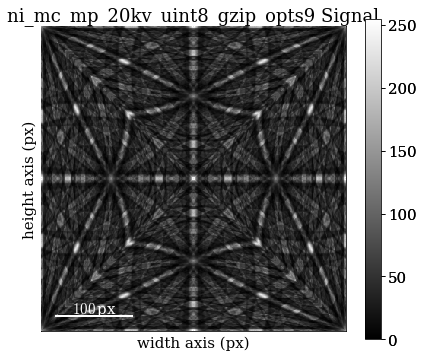

In [5]:
mp.plot()

The Nickel phase information, specifically the crystal symmetry, asymmetric atom
positions, and crystal lattice, is conveniently stored in an
[orix.crystal_map.Phase](https://orix.readthedocs.io/en/stable/reference.html#orix.crystal_map.Phase)

In [6]:
ni = mp.phase
ni

<name: ni. space group: Fm-3m. point group: m-3m. proper point group: 432. color: tab:blue>

In [7]:
ni.structure  # Element, x, y, z, site occupation

[28   0.000000 0.000000 0.000000 1.0000]

In [8]:
ni.structure.lattice  # nm and degrees

Lattice(a=0.35236, b=0.35236, c=0.35236, alpha=90, beta=90, gamma=90)

### Sample orientation space

If we don't know anything about the possible crystal (unit cell) orientations in
our sample, the safest thing to do is to generate a dictionary of orientations
uniformly distributed in a candidate phase's orientation space. To achieve this,
we sample the Rodrigues Fundamental Zone of the proper point group *432* using
cubochoric sampling <cite data-cite="singh2016orientation">Singh and De Graef
(2016)</cite> available in
[orix.sampling.get_sample_fundamental()](https://orix.readthedocs.io/en/stable/reference.html#orix.sampling.get_sample_fundamental). We can
choose the average disorientation between orientations, the "resolution", of
this sampling. Here, we will use a very low resolution of 4$^{\circ}$.

<div class="alert alert-info">

Note

Cubochoric sampling became available in orix v0.7.

</div>

In [9]:
rotations = sampling.get_sample_fundamental(
    method="cubochoric", resolution=4, point_group=ni.point_group
)
rotations

Rotation (11935,)
[[ 0.8606 -0.3337 -0.3337 -0.1912]
 [ 0.8606 -0.3397 -0.3397 -0.1687]
 [ 0.8606 -0.345  -0.345  -0.1456]
 ...
 [ 0.8606  0.345   0.345   0.1456]
 [ 0.8606  0.3397  0.3397  0.1687]
 [ 0.8606  0.3337  0.3337  0.1912]]

This sampling resulted in 11 935 crystal orientations. See the [orix user guide
on orientation sampling](https://orix.readthedocs.io/en/stable/uniform_sampling_of_orientation_space.html)
for further details and options for orientation sampling.

<div class="alert alert-info">

Note

An average disorientation of 4$^{\circ}$ results in a course sampling of
orientation space; a lower average disorientation should be used for
experimental work.

</div>

### Define the detector-sample-geometry

Now that we have our master pattern and crystal orientations, we need to
describe the EBSD detector's position with respect to the sample (interaction
volume). This ensures that projecting parts of the master pattern onto our
detector yields dynamically simulated patterns resembling our experimental ones.
See the [reference frames](reference_frames.rst) user guide and the
[EBSDDetector](../reference.rst#kikuchipy.detectors.EBSDDetector)
class for further details.

In [10]:
signal_shape = s.axes_manager.signal_shape[::-1]
detector = kp.detectors.EBSDDetector(
    shape=signal_shape,
    pc=[0.421, 0.7794, 0.5049],
    sample_tilt=70,
    convention="tsl",
)
detector

EBSDDetector (60, 60), px_size 1 um, binning 1, tilt 0, azimuthal 0, pc (0.421, 0.221, 0.505)

Let's double check the projection/pattern center (PC) position on the detector
using
[plot()](../reference.rst#kikuchipy.detectors.EBSDDetector.plot)

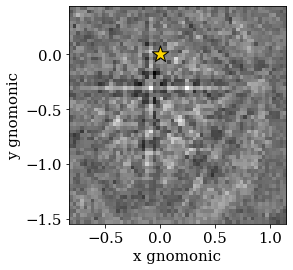

In [11]:
detector.plot(coordinates="gnomonic", pattern=s.inav[0, 0].data)

### Generate dictionary

Now we're ready to generate our dictionary of simulated patterns by projecting
parts of the master pattern onto our detector for all sampled orientations,
using the
[get_patterns()](../reference.rst#kikuchipy.signals.ebsdmasterpattern.get_patterns)
method. The method assumes the crystal orientations are represented with respect
to the EDAX TSL sample reference frame RD-TD-ND.

<div class="alert alert-info">

Note

It is in general adviced to not compute the dictionary immediately, but let the
dictionary indexing method handle this, by passing `compute=False`. This will
return a `LazyEBSD` signal, with the dictionary patterns as a
[dask array](https://docs.dask.org/en/latest/array.html).

</div>

In [12]:
sim = mp.get_patterns(
    rotations=rotations,
    detector=detector,
    energy=energy,
    dtype_out=np.float32,
    compute=True
)
sim

Creating a dictionary of (11935,) simulated patterns:
[########################################] | 100% Completed |  2.2s


<EBSD, title: , dimensions: (11935|60, 60)>

Let's inspect the three first of the 11 935 simulated patterns

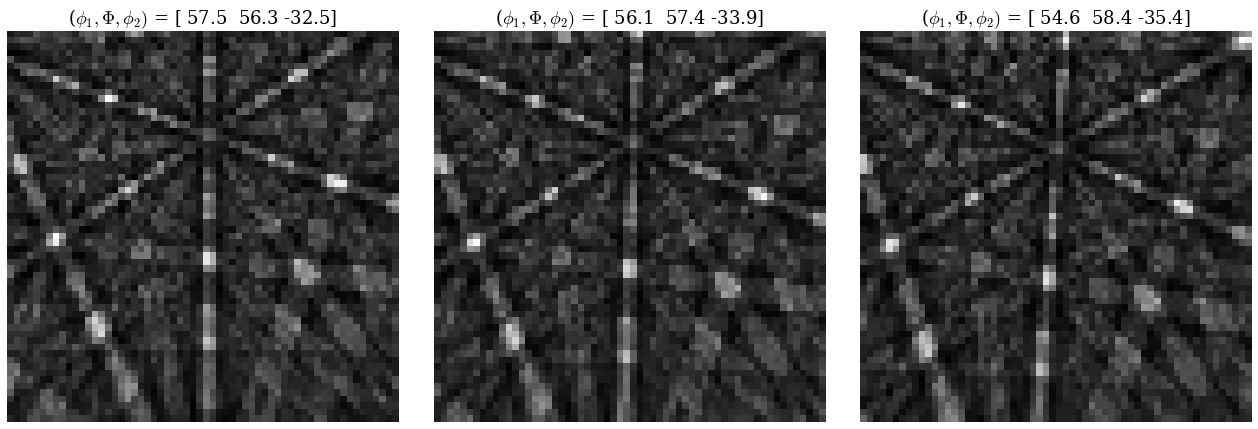

In [13]:
#sim.plot()  # Plot the patterns with a navigator for easy inspection
fig, ax = plt.subplots(ncols=3, figsize=(18, 6))
for i in range(3):
    ax[i].imshow(sim.inav[i].data, cmap="gray")
    euler = np.rad2deg(sim.xmap[i].rotations.to_euler())[0]
    ax[i].set_title(
        f"($\phi_1, \Phi, \phi_2)$ = {np.array_str(euler, precision=1)}"
    )
    ax[i].axis("off")
fig.tight_layout()

### Perform indexing

*Signal masking was added in version: 0.5.*

The Kikuchi pattern signal is usually weak towards the corners of the detector,
so we can pass a signal mask to only match the pixels where the mask values are
``False``, i.e. mask out the values that are ``True``. This convention is in
line with how NumPy, Dask, scikit-image etc. defines a mask. We can pass
whatever mask we want, as long as it is a boolean array of the detector shape.

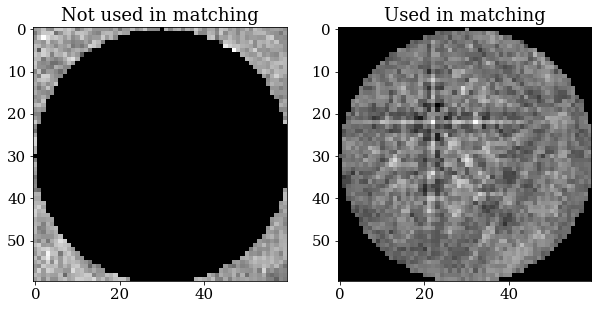

In [14]:
signal_mask = ~kp.filters.Window("circular", signal_shape).astype(bool)

p = s.inav[0, 0].data
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(p * signal_mask, cmap="gray")
ax[0].set_title("Not used in matching")
ax[1].imshow(p * ~signal_mask, cmap="gray")
ax[1].set_title("Used in matching");

Finally, let's use the
[dictionary_indexing()](../reference.rst#kikuchipy.signals.EBSD.dictionary_indexing)
method to match the simulated patterns to our experimental patterns, using
the [zero-mean normalized cross correlation (NCC)](../reference.rst#kikuchipy.indexing.similarity_metrics.NormalizedCrossCorrelationMetric)
coefficient $r$
<cite data-cite="gonzalez2017digital">Gonzalez & Woods (2017)</cite>, which is
the default similarity metric. Let's keep the 10 best matching orientations. A
number of 4125 * 14423 comparisons is quite small, which we can do in memory all
at once. However, in cases where the number of comparisons are too big for our
memory to handle, we should iterate over the dictionary of simulated patterns
by passing the number of patterns per iteration. To demonstrate this, we do at
least 10 iterations here. The results are returned as a
[orix.crystal_map.CrystalMap](https://orix.readthedocs.io/en/stable/reference.html#crystalmap).

In [15]:
xmap = s.dictionary_indexing(
    sim,
    metric="ncc",
    keep_n=10,
    n_per_iteration=sim.axes_manager.navigation_size // 10,
    signal_mask=signal_mask
)
xmap

Dictionary indexing information:
	Phase name: ni
	Matching 4125 experimental pattern(s) to 11935 dictionary pattern(s)
	NormalizedCrossCorrelationMetric: float32, greater is better, rechunk: False, signal mask: True


100%|████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  1.94it/s]


Phase   Orientations  Name  Space group  Point group  Proper point group     Color
    0  4125 (100.0%)    ni        Fm-3m         m-3m                 432  tab:blue
Properties: scores, simulation_indices
Scan unit: px

<div class="alert alert-info">

Note

*Added in version: 0.5.*
    
Dictionary indexing of real world data sets takes a long time because the
matching is computationally intensive. The
[dictionary_indexing()](../reference.rst#kikuchipy.signals.EBSD.dictionary_indexing)
method accepts parameters *n_per_iteration*, *rechunk* and *dtype* that lets us
control this behaviour to a certain extent, so be sure to take a look at the
method's docstring.

</div>

The [normalized dot product](../reference.rst#kikuchipy.indexing.similarity_metrics.NormalizedDotProductMetric)
can be used instead of the NCC by passing `metric="ndp"`. A custom metric can
be used instead, by creating a class which inherits from the abstract class
[SimilarityMetric](../reference.rst#kikuchipy.indexing.similarity_metrics.SimilarityMetric).

The results can be exported to an HDF5 file re-readable by orix

In [16]:
temp_dir = tempfile.mkdtemp() + "/"
xmap_file = temp_dir + "ni.h5"
io.save(xmap_file, xmap)

/home/hakon/miniconda3/envs/kp-dev/lib/python3.9/site-packages/orix/quaternion/rotation.py:312: RuntimeWarning: invalid value encountered in true_divide
  np.divide(b * d - a * c, chi), np.divide(-a * b - c * d, chi)
/home/hakon/miniconda3/envs/kp-dev/lib/python3.9/site-packages/orix/quaternion/rotation.py:316: RuntimeWarning: invalid value encountered in true_divide
  np.divide(a * c + b * d, chi), np.divide(c * d - a * b, chi)


### Inspect indexing results

So far, the [orix library](https://orix.readthedocs.io) cannot produce any
orientation color maps, pole figures etc. This has to be done in other software,
like MTEX.

Here, we'll inspect the map of best matching scores and a so-called orientation
similarity (OS) map, which compares the best matching orientations for each
pattern to it’s nearest neighbours.

Let's get the NCC map in the correct shape from the CrystalMap’s scores property
and the OS map with
[orientation_similarity_map()](../reference.rst#kikuchipy.indexing.orientation_similarity_map)
using the full list of 10 best matches per point

In [17]:
ncc_map = xmap.scores[:, 0].reshape(*xmap.shape)
os_map = kp.indexing.orientation_similarity_map(xmap)

And plot the maps

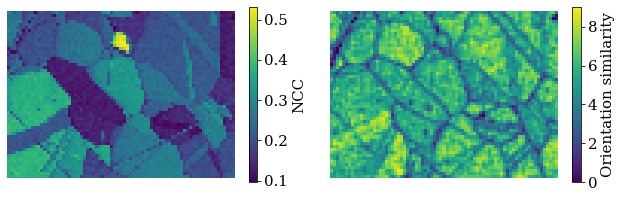

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 3))

im0 = ax[0].imshow(ncc_map)
ax[0].axis("off")
fig.colorbar(im0, ax=ax[0], label="NCC")

im1 = ax[1].imshow(os_map)
ax[1].axis("off")
fig.colorbar(im1, ax=ax[1], label="Orientation similarity")

fig.tight_layout();

We can see that some of the grains have orientations which doesn't match that
well to any orientation (pattern) in the dictionary. Note that refinment will
not be able to improve much upon those orientations that didn't get a good match
from DI. The simplest way to improve the results for the darker grains is to
reduce the orientation sampling characteristic distance. This will increase our
dictionary size and thus our indexing time, but will lead to better results.

We can use the crystal map property `simulation_indices` to get the best
matching simulated patterns from the dictionary of simulated patterns

In [19]:
best_patterns = sim.data[xmap.simulation_indices[:, 0]].reshape(s.data.shape)
s_best = kp.signals.EBSD(best_patterns)
s_best

<EBSD, title: , dimensions: (75, 55|60, 60)>

The simplest way to visually compare the experimental and best matching
simulated patterns are to
[plot them in the same navigator](visualizing_patterns.ipynb#plot-multiple-signals).
Here, we use the highest $r$ as a navigator. When using an interactive backend
like `Qt5Agg`, we can then move the red square around to look at the patterns in
each point.

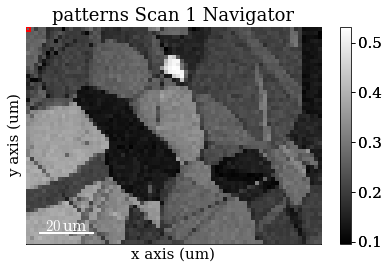

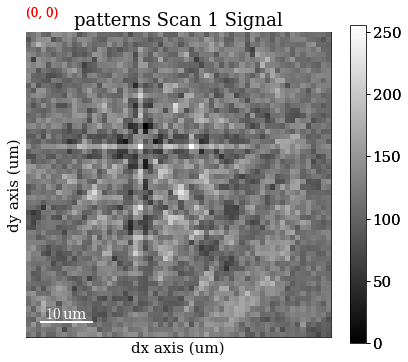

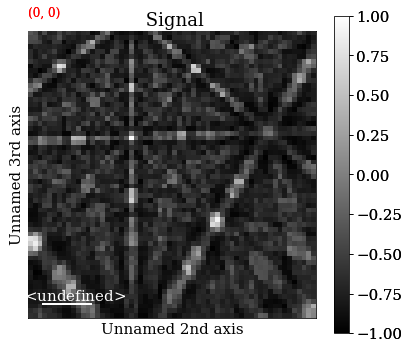

In [20]:
ncc_navigator = hs.signals.Signal2D(xmap.get_map_data(xmap.scores[:, 0]))
hs.plot.plot_signals([s, s_best], navigator=ncc_navigator)

Let's also plot the best matches for patterns from two grains

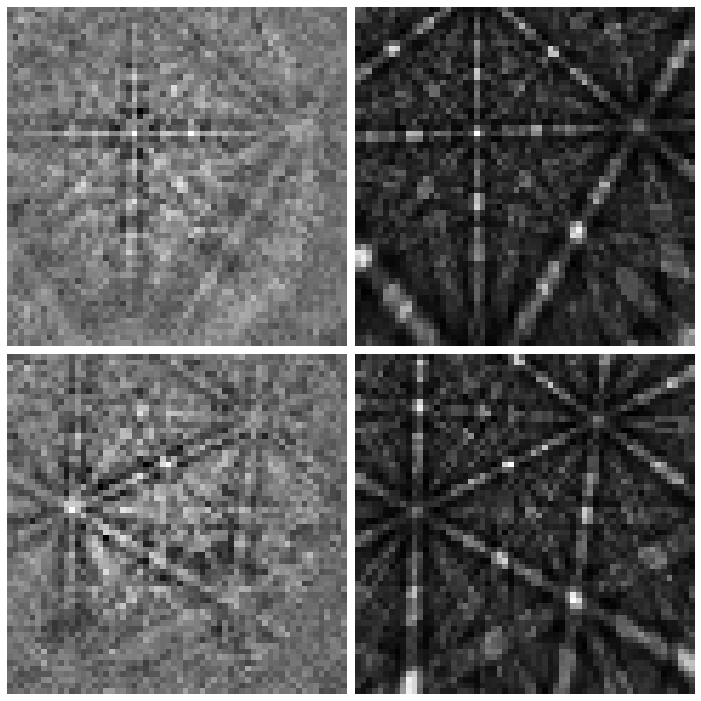

In [21]:
grain1 = (0, 0)
grain2 = (30, 10)
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
ax[0, 0].imshow(s.inav[grain1].data, cmap="gray")
ax[0, 0].axis("off")
ax[0, 1].imshow(s_best.inav[grain1].data, cmap="gray")
ax[0, 1].axis("off")
ax[1, 0].imshow(s.inav[grain2].data, cmap="gray")
ax[1, 0].axis("off")
ax[1, 1].imshow(s_best.inav[grain2].data, cmap="gray")
ax[1, 1].axis("off")
fig.tight_layout(h_pad=0.5, w_pad=1)

## Refinement

Let's look at the effect of three refinement routes, all implemented as `EBSD`
methods:

1. Refine orientations while keeping the PCs fixed: [refine_orientation()](../reference.rst#kikuchipy.signals.EBSD.refine_orientation) 
2. Refine PCs while keeping the orientations fixed: [refine_projection_center()](../reference.rst#kikuchipy.signals.EBSD.refine_projection_center) 
3. Refine orientations and PCs at the same time: [refine_orientation_projection_center()](../reference.rst#kikuchipy.signals.EBSD.refine_orientation_projection_center) 

For each run we will compare the maps and histograms of NCC scores before and
after refinement, and also the PC parameters if appropriate.

As stated at the top, we use the numerical optimization routines from the
[SciPy library](https://docs.scipy.org/doc/scipy/reference/optimize.html). For
every orientation and/or PC, we want to iteratively increase the similarity (NCC
score) between our experimental pattern and a new simulated pattern projected
onto our EBSD detector for every iteration until the score increase from one
iteration to the next is below a certain threshold, by default 0.0001 in most
cases. The orientation and/or PC is updated slightly for every iteration. We
have access to both local and global optimization algorithms. Consult the
kikuchipy docstring methods linked below and the SciPy documentation for all
available options.

Note that while we here refine orientations obtained from DI, any orientation
results, e.g. from Hough indexing, can be refined with this approach, as long as
an appropriate master pattern and
[EBSDDetector](../reference.rst#kikuchipy.detectors.EBSDDetector) is provided,
and the orientation results are passed as a
[CrystalMap](https://orix.readthedocs.io/en/stable/reference.html#orix.crystal_map.CrystalMap).

### Refine orientations

We use
[refine_orientation()](../reference.rst#kikuchipy.signals.EBSD.refine_orientation)
to refine orientations while keeping the PCs fixed, using the default local
Nelder-Mead simplex method

In [22]:
xmap_refined = s.refine_orientation(
    xmap=xmap,
    detector=detector,
    master_pattern=mp,
    energy=energy,
    method="minimize",  # Default
    method_kwargs=dict(method="Nelder-Mead", options=dict(fatol=1e-4)),  # Default    
    compute=True,
)

Refinement information:
	Local optimization method: Nelder-Mead (minimize)
	Keyword arguments passed to method: {'method': 'Nelder-Mead', 'options': {'fatol': 0.0001}}
Refining 4125 orientation(s):
[########################################] | 100% Completed |  1min 13.7s


Compare the NCC score maps. We use the same colorbar bounds for both maps

In [23]:
ncc_after_orientation_refinement = xmap_refined.get_map_data("scores")

ncc_di_min = np.min(ncc_map)
ncc_di_max = np.max(ncc_map)
ncc_ori_ref_min = np.min(ncc_after_orientation_refinement)
ncc_ori_ref_max = np.max(ncc_after_orientation_refinement)

vmin = min([ncc_di_min, ncc_ori_ref_min])
vmax = max([ncc_di_max, ncc_ori_ref_max])

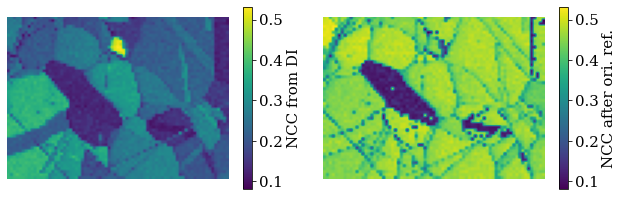

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 3))
im0 = ax[0].imshow(ncc_map, vmin=vmin, vmax=vmax)
ax[0].axis("off")
fig.colorbar(im0, ax=ax[0], label="NCC from DI")
im1 = ax[1].imshow(ncc_after_orientation_refinement, vmin=vmin, vmax=vmax)
ax[1].axis("off")
ncc_after_label = "NCC after ori. ref."
fig.colorbar(im1, ax=ax[1], label=ncc_after_label)
fig.tight_layout();

Compare the histograms

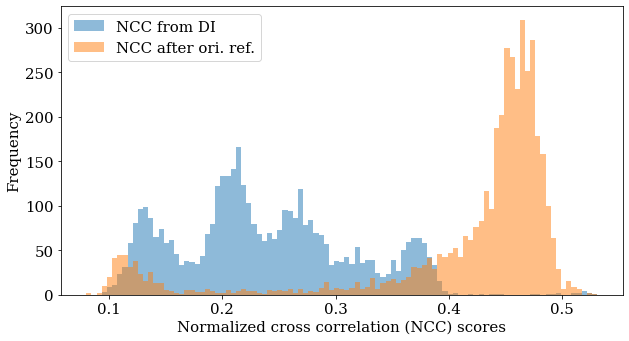

In [25]:
bins = np.linspace(vmin, vmax, 100)
fig, ax = plt.subplots(figsize=(9, 5))
_ = ax.hist(ncc_map.ravel(), bins, alpha=0.5, label="NCC from DI")
_ = ax.hist(
    ncc_after_orientation_refinement.ravel(),
    bins,
    alpha=0.5,
    label=ncc_after_label,
)
ax.set_xlabel("Normalized cross correlation (NCC) scores")
ax.set_ylabel("Frequency")
ax.legend()
fig.tight_layout();

We can see that orientation refinement found the best orientation
(with a fixed PC) for most of the grains, but not for the ones which didn't find
the correct best match in the dictionary. Clearly, the dictionary is too sparse.

### Refine projection centers

We use
[refine_projection_center()](../reference.rst#kikuchipy.signals.EBSD.refine_projection_center)
to refine PCs while keeping the orientations fixed, using the local modified
Powell method. This method is also known as Bound Optimization BY Quadratic
Approximation (BOBYQA), and is used in EMsoft and discussed by
<cite data-cite="singh2017application">Singh et al. (2017)</cite>. We will pass
a `trust_region` of +/- 5% for the PC parameters to use as upper and lower
bounds during refinement.

We can also pass `compute=False`, to do the
refinement later. The results will then be a list of
[dask.delayed.Delayed](https://docs.dask.org/en/latest/delayed-api.html#dask.delayed.Delayed)
instances. We can pass this list to
[kikuchipy.indexing.compute_refine_projection_center_results()](../reference.rst#kikuchipy.indexing.compute_refine_projection_center_results)
and perform the refinement to retrieve the results

In [26]:
delayed_results = s.refine_projection_center(
    xmap=xmap,
    detector=detector,
    master_pattern=mp,
    energy=energy,
    method="minimize",
    method_kwargs=dict(method="Powell", options=dict(ftol=1e-3)),
    trust_region=[0.05, 0.05, 0.05],
    compute=False,
)

Refinement information:
	Local optimization method: Powell (minimize)
	Keyword arguments passed to method: {'method': 'Powell', 'options': {'ftol': 0.001}}
	Trust region: [0.05, 0.05, 0.05]


In [27]:
ncc_after_pc_refinement, detector_refined = kp.indexing.compute_refine_projection_center_results(
    results=delayed_results, detector=detector, xmap=xmap
)

Refining 4125 projection center(s):
[########################################] | 100% Completed |  1min 39.3s


Note that `refine_orientation()` and `refine_orientation_projection_center()`
also takes the `compute` parameter, and there similar functions to compute the
refinement results:
[kikuchipy.indexing.compute_refine_orientation_results()](../reference.rst#kikuchipy.indexing.compute_refine_orientation_results)
and
[kikuchipy.indexing.compute_refine_orientation_projection_center_results()](../reference.rst#kikuchipy.indexing.compute_refine_orientation_projection_center_results).

Let's plot the refined scores and PCs

In [28]:
ncc_pc_ref_min = np.min(ncc_after_pc_refinement)
ncc_pc_ref_max = np.max(ncc_after_pc_refinement)

vmin2 = min([ncc_di_min, ncc_pc_ref_min])
vmax2 = max([ncc_di_max, ncc_pc_ref_max])

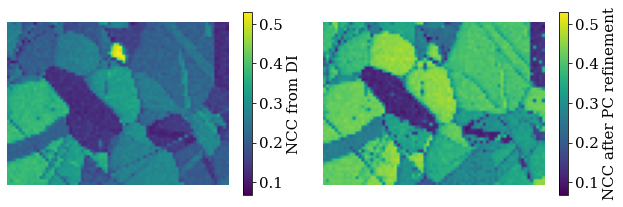

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 3))
im0 = ax[0].imshow(ncc_map, vmin=vmin2, vmax=vmax2)
ax[0].axis("off")
fig.colorbar(im0, ax=ax[0], label="NCC from DI")
im1 = ax[1].imshow(ncc_after_pc_refinement, vmin=vmin2, vmax=vmax2)
ax[1].axis("off")
ncc_after_pc_label = "NCC after PC refinement"
fig.colorbar(im1, ax=ax[1], label=ncc_after_pc_label)
fig.tight_layout();

Compare the histograms

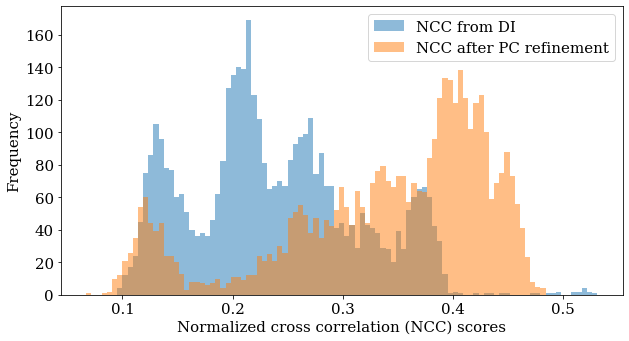

In [30]:
bins = np.linspace(vmin2, vmax2, 100)
fig, ax = plt.subplots(figsize=(9, 5))
_ = ax.hist(ncc_map.ravel(), bins, alpha=0.5, label="NCC from DI")
_ = ax.hist(
    ncc_after_pc_refinement.ravel(),
    bins,
    alpha=0.5,
    label=ncc_after_pc_label,
)
ax.set_xlabel("Normalized cross correlation (NCC) scores")
ax.set_ylabel("Frequency")
ax.legend()
fig.tight_layout();

PC used in DI:		[0.421 0.221 0.505]
PC after PC refinement:	[0.421 0.224 0.507]


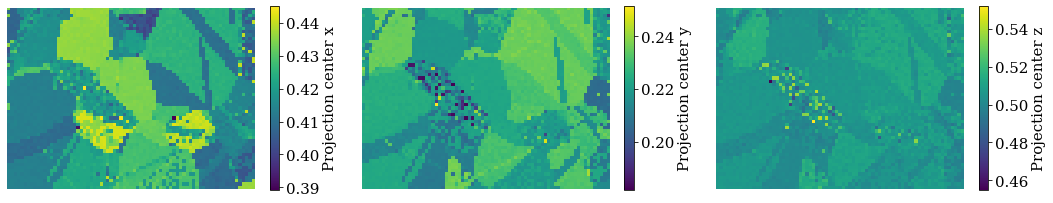

In [31]:
print(
    f"PC used in DI:\t\t{detector.pc_average}\n"
    f"PC after PC refinement:\t{detector_refined.pc_average}"
)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
im0 = ax[0].imshow(detector_refined.pcx)
fig.colorbar(im0, ax=ax[0], label="Projection center x")
ax[0].axis("off")
im1 = ax[1].imshow(detector_refined.pcy)
fig.colorbar(im1, ax=ax[1], label="Projection center y")
ax[1].axis("off")
im2 = ax[2].imshow(detector_refined.pcz)
fig.colorbar(im2, ax=ax[2], label="Projection center z")
ax[2].axis("off")
fig.tight_layout();

### Refine orientations and projection centers

We use
[refine_orientation_projection_center()](../reference.rst#kikuchipy.signals.EBSD.refine_orientation_projection_center)
to refine orientations and PCs at the same time. For the purpose of saving time
and computation resources here, we'll just do this for the upper left quarter of
the data set

In [32]:
nav_shape = s.axes_manager.navigation_shape[::-1]
y1, x1 = np.array(nav_shape) // 2
slices2d = (slice(0, y1), slice(0, x1))

In [33]:
s2 = s.inav[slices2d[::-1]]  # HyperSpy flips the usual NumPy (row, column) to (column, row)
s2

<EBSD, title: patterns Scan 1, dimensions: (37, 27|60, 60)>

In [34]:
xmap2 = xmap[slices2d]
xmap2

Phase  Orientations  Name  Space group  Point group  Proper point group     Color
    0  999 (100.0%)    ni        Fm-3m         m-3m                 432  tab:blue
Properties: scores, simulation_indices
Scan unit: px

In [35]:
xmap_refined2, detector_refined2 = s2.refine_orientation_projection_center(
    xmap=xmap2,
    detector=detector,
    master_pattern=mp,
    energy=energy,
    method="minimize",
    method_kwargs=dict(options=dict(fatol=1e-3)),
    compute=True,
)

Refinement information:
	Local optimization method: Nelder-Mead (minimize)
	Keyword arguments passed to method: {'options': {'fatol': 0.001}, 'method': 'Nelder-Mead'}
Refining 999 orientation(s) and projection center(s):
[########################################] | 100% Completed |  1min 19.5s


In [36]:
xmap_refined2

Phase  Orientations  Name  Space group  Point group  Proper point group     Color
    0  999 (100.0%)    ni        Fm-3m         m-3m                 432  tab:blue
Properties: scores
Scan unit: px

Compare the NCC score maps. We use the same colorbar bounds for both maps

In [37]:
ncc_after_orientation_pc_refinement = xmap_refined2.get_map_data("scores")
ncc_map2 = ncc_map[slices2d]

ncc2_di_min = np.min(ncc_map2)
ncc2_di_max = np.max(ncc_map2)
ncc_ori_pc_ref_min = np.min(ncc_after_orientation_pc_refinement)
ncc_ori_pc_ref_max = np.max(ncc_after_orientation_pc_refinement)

vmin3 = min([ncc2_di_min, ncc_ori_pc_ref_min])
vmax3 = max([ncc2_di_max, ncc_ori_pc_ref_max])

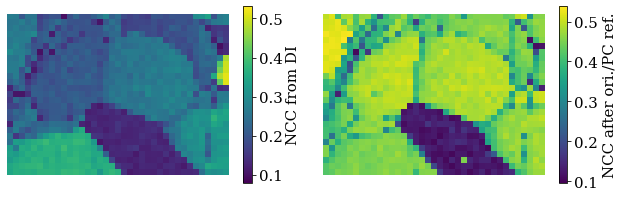

In [38]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 3))
im0 = ax[0].imshow(ncc_map2, vmin=vmin, vmax=vmax)
ax[0].axis("off")
fig.colorbar(im0, ax=ax[0], label="NCC from DI")
im1 = ax[1].imshow(ncc_after_orientation_pc_refinement, vmin=vmin3, vmax=vmax3)
ax[1].axis("off")
ncc_after_ori_pc_label = "NCC after ori./PC ref."
fig.colorbar(im1, ax=ax[1], label=ncc_after_ori_pc_label)
fig.tight_layout();

Compare the histograms

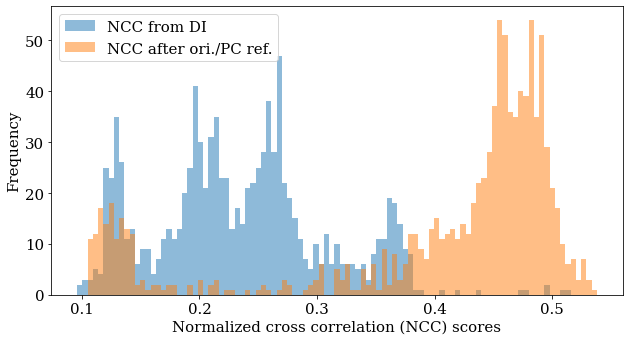

In [39]:
bins = np.linspace(vmin3, vmax3, 100)
fig, ax = plt.subplots(figsize=(9, 5))
_ = ax.hist(ncc_map2.ravel(), bins, alpha=0.5, label="NCC from DI")
_ = ax.hist(
    ncc_after_orientation_pc_refinement.ravel(),
    bins,
    alpha=0.5,
    label=ncc_after_ori_pc_label,
)
ax.set_xlabel("Normalized cross correlation (NCC) scores")
ax.set_ylabel("Frequency")
ax.legend()
fig.tight_layout();

Let's also inspect the refined PC parameters

PC used in DI:		[0.421 0.221 0.505]
PC after PC refinement:	[0.423 0.215 0.501]


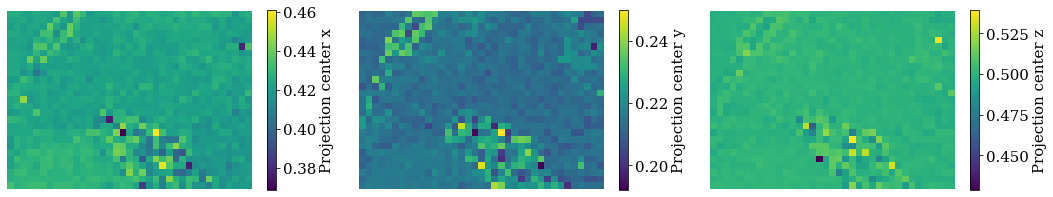

In [40]:
print(
    f"PC used in DI:\t\t{detector.pc_average}\n"
    f"PC after PC refinement:\t{detector_refined2.pc_average}"
)

fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
im0 = ax[0].imshow(detector_refined2.pcx)
fig.colorbar(im0, ax=ax[0], label="Projection center x")
ax[0].axis("off")
im1 = ax[1].imshow(detector_refined2.pcy)
fig.colorbar(im1, ax=ax[1], label="Projection center y")
ax[1].axis("off")
im2 = ax[2].imshow(detector_refined2.pcz)
fig.colorbar(im2, ax=ax[2], label="Projection center z")
ax[2].axis("off")
fig.tight_layout();

In [41]:
# Remove files written to disk in this user guide
import os
os.remove(xmap_file)
os.rmdir(temp_dir)